# Taxi problem

Follow the tutorial: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [1]:
import gym
from IPython.display import clear_output
from time import sleep
import time
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The filled square represents the taxi, which is yellow without a passenger and green with a passenger.

The pipe ("|") represents a wall which the taxi cannot cross.

R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

In [3]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


In [4]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



# Random Policy

In [5]:
env.s = 328  # set environment to illustration's state

steps = 0
penalties, rw = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample() #Select a random action
    state, reward, done, info = env.step(action) #implement action

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': rw
        }
    )

    steps += 1    

In [6]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

#visialize 1 episode
print_frames(frames)   
print("Timesteps taken: {}".format(steps))
print("Penalties incurred: {}".format(penalties))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1673
State: 0
Action: 5
Reward: 0
Timesteps taken: 1673
Penalties incurred: 568


In [7]:
"""Evaluate random policy"""
sum_epochs = 0
sum_penalties = 0
episodes = 100
episode_reward_list = []

tic = time.perf_counter()
#loop through 100 episodes
for _ in range(episodes):
    #set current state to starting environment
    state = env.reset()
    step, penalties, ep_reward = 0, 0, 0
    
    #done = successfully dropped off passenger
    done = False

    #while not successfully drop off passenger
    while not done:
        #select a random action
        action = env.action_space.sample()
        
        #apply the action
        state, rw, done, info = env.step(action)
        ep_reward += rw

        #set penalty based on reward value for action
        if rw == -10:
            penalties += 1
        #increment episode steps
        step += 1

    #after 1 episode, sum penalties and episodes
    sum_penalties += penalties
    sum_epochs += step
    episode_reward_list.append(ep_reward)

toc = time.perf_counter()
average_time = (toc - tic)/episodes
#print evaluation of agents performance
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {sum_epochs / episodes}")
print(f"Average penalties per episode: {sum_penalties / episodes}")
print(f"Average reward per timestep: {sum(episode_reward_list) / sum_epochs}")
print(f"Average time per episode: {average_time:0.4f} seconds")

Results after 100 episodes:
Average timesteps per episode: 2316.05
Average penalties per episode: 750.2
Average reward per timestep: -3.9061548757582956
Average time per episode: 0.0211 seconds


# Q-learning

In [8]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [9]:
def policy(state):
    if random.uniform(0, 1) >= epsilon:
        return np.argmax(q_table[state]) # Exploit learnt values
    else:
        return env.action_space.sample() # Explore action space

In [10]:
%%time
"""Training the agent"""
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
training_epochs = []
training_penalties = []
q_reward = []

for i in range(100000):
    #Initialize new state
    state = env.reset()

    steps, penalties, ep_reward = 0, 0, 0
    done = False
    
    #while not successfully drop off passenger
    while not done:
        #Select an action
        action = policy(state)
        
        #Implement the action
        next_state, rw, done, _ = env.step(action) 
        
        #Update a episode reward
        ep_reward+= rw
        
        #Update q-value
        next_max = np.max(q_table[next_state])        
        new_value = (1 - alpha) * q_table[state, action] + alpha * (rw + gamma * next_max)
        q_table[state, action] = new_value #update new q value

        if rw == -10:
            penalties += 1

        state = next_state #move to next state
        steps += 1
    q_reward.append(ep_reward)
    training_epochs.append(steps)
    training_penalties.append(penalties)    

print("Training finished")

Training finished
Wall time: 23.8 s


In [11]:
#Check q-value at state 328
q_table[328]

array([ -2.40683144,  -2.27325184,  -2.4107527 ,  -2.35705517,
       -10.75067826, -10.52581907])

In [12]:
"""Evaluate agent's performance after Q-learning"""

sum_epochs, sum_penalties = 0, 0
episodes = 100
episode_reward_list = []

#for timing
tic = time.perf_counter()

for _ in range(episodes):
    state = env.reset() #reset the environment
    steps, penalties, ep_reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action) #select an action
        ep_reward += reward

        if reward == -10:
            penalties += 1

        steps += 1
    #after 1 episode, sum penalties and episodes
    sum_penalties += penalties
    sum_epochs += steps
    episode_reward_list.append(ep_reward)
    episode_reward = 0

toc = time.perf_counter()
average_time = (toc - tic)/episodes
#print evaluation of agents performance
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {sum_epochs / episodes}")
print(f"Average penalties per episode: {sum_penalties / episodes}")
print(f"Average reward per timestep: {sum(episode_reward_list) / sum_epochs}")
print(f"Average time per episode: {average_time:0.4f} seconds")

Results after 100 episodes:
Average timesteps per episode: 13.19
Average penalties per episode: 0.0
Average reward per timestep: 0.5921152388172858
Average time per episode: 0.0002 seconds


# TD Learning

In [13]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [14]:
%%time
"""Training the agent"""

# For plotting metrics
td_reward = [] #Cumlative reward after training
sum_penalties = 0

for i in range(100000):
    state = env.reset()

    ep_reward, penalties= 0,0 #penalty in 1 episode
    
    done = False
    action = policy(state)
    
    while not done:
        #implement action
        next_state, rw, done, info = env.step(action) 
        
        ep_reward += rw
        
        #Update the next action
        next_action = policy(next_state)
        
        #Update q-value       
        q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (rw + gamma * q_table[next_state, next_action])
        
        #assign penalties
        if rw == -10:
            penalties += 1

        state, action = next_state, next_action #move to next state, next action
        
    #update reward and total penalties
    td_reward.append(ep_reward)
    sum_penalties+=penalties

print("Training finished.\n")

Training finished.

Wall time: 1min 53s


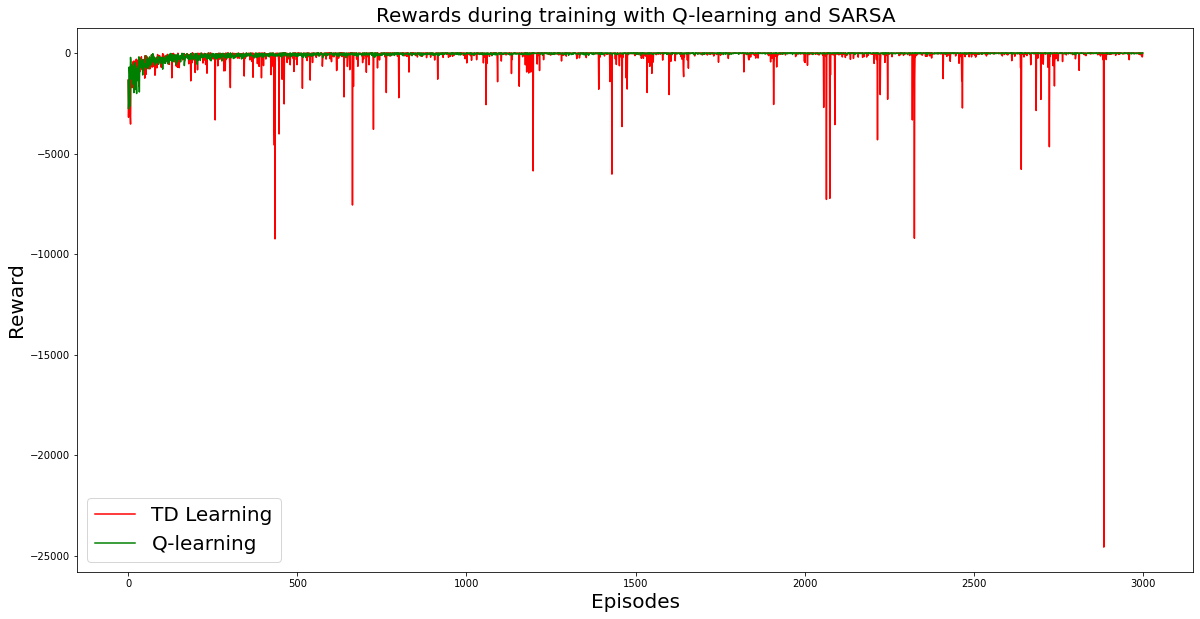

In [17]:
'''Visualize rewards in training'''
plt.figure(figsize=(20,10))
plt.plot(range(len(td_reward[:3000])),td_reward[:3000], color = "r")
plt.plot(range(len(q_reward[:3000])),q_reward[:3000], color = "g")
plt.title("Rewards during training with Q-learning and SARSA",fontsize = 20)
plt.xlabel("Episodes",fontsize = 20)
plt.ylabel("Reward",fontsize = 20)
plt.legend(["TD Learning", "Q-learning"],fontsize = 20)
plt.show()